# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [ ]:
import random

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох 3000
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [ ]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

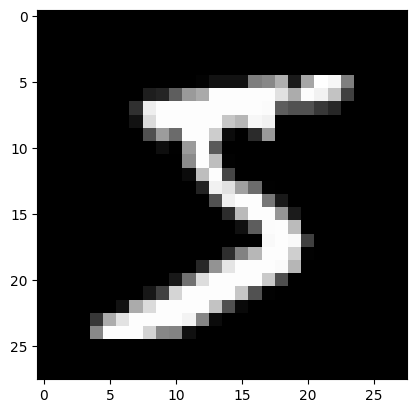

In [ ]:
plt.imshow(x_train[0].reshape(28, 28), cmap="gray")

In [ ]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, activation="sigmoid", name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([in_features, out_features], stddev=0.05), name="w")
        self.b = tf.Variable(tf.zeros([out_features]), name="b")
        self.activation = activation

    def __call__(self, x):
        y_in = tf.matmul(x, self.w) + self.b
        if self.activation == "relu":
            y = tf.nn.relu(y_in)
        elif self.activation == "softmax":
            y = tf.nn.softmax(y_in)
        elif self.activation == "sigmoid":
            y = tf.nn.sigmoid(y_in)

        return y


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    # Место для вашего кода
    self.layer_1 = DenseLayer(in_features=28*28, out_features=n_hidden_1)
    # Второй слой, состоящий из 256 нейронов
    # Место для вашего кода
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
    # Выходной слой
    # Место для вашего кода
    self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=10, activation="softmax")

  def __call__(self, x):
    # Место для вашего кода
    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax.
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью
    # принадлежности входного объекта к одному из 10 классов
    x = self.layer_1(x)
    x = self.layer_2(x)
    x = self.layer_3(x)
    # return tf.nn.softmax(x)
    return x

In [ ]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(
        tf.argmax(y_pred, 1),
        tf.cast(y_true, tf.int64)
    )
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [ ]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Создадим оптимизируемых список параметров
    nn_variables = nn.variables

    # Вычислим по ним значение градиента
    gradients = g.gradient(loss, nn_variables)

    # Модифицируем параметры
    optimizer.apply_gradients(zip(gradients, nn_variables))
  return pred

In [ ]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

  # В этом цикле мы будем производить обучение нейронной сети
  # из тренировочного датасета train_data извлеките случайное подмножество, на котором
  # произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data):
  # Обновляем веса нейронной сети
  pred = train(neural_net, batch_x, batch_y)
  if step % display_step == 0:
    cross = cross_entropy(pred, batch_y)
    acc = accuracy(pred, batch_y)
    loss_history.append(cross)
    accuracy_history.append(acc)
    print(f"{step}, {cross._numpy()=} , {acc._numpy()=}")

  if step > training_steps:
    print(f"End training after {training_steps} steps")
    break

0, cross._numpy()=602.8826 , acc._numpy()=0.08984375
100, cross._numpy()=585.1631 , acc._numpy()=0.18359375
200, cross._numpy()=405.00507 , acc._numpy()=0.6015625
300, cross._numpy()=243.39555 , acc._numpy()=0.7109375
400, cross._numpy()=190.08936 , acc._numpy()=0.796875
500, cross._numpy()=149.40628 , acc._numpy()=0.796875
600, cross._numpy()=121.50366 , acc._numpy()=0.87109375
700, cross._numpy()=121.81004 , acc._numpy()=0.86328125
800, cross._numpy()=88.13793 , acc._numpy()=0.90234375
900, cross._numpy()=101.34375 , acc._numpy()=0.890625
1000, cross._numpy()=90.56239 , acc._numpy()=0.8984375
1100, cross._numpy()=98.35725 , acc._numpy()=0.90625
1200, cross._numpy()=112.70409 , acc._numpy()=0.8828125
1300, cross._numpy()=95.53723 , acc._numpy()=0.890625
1400, cross._numpy()=103.668915 , acc._numpy()=0.890625
1500, cross._numpy()=79.92911 , acc._numpy()=0.93359375
1600, cross._numpy()=80.22156 , acc._numpy()=0.91796875
1700, cross._numpy()=77.19604 , acc._numpy()=0.91796875
1800, cross

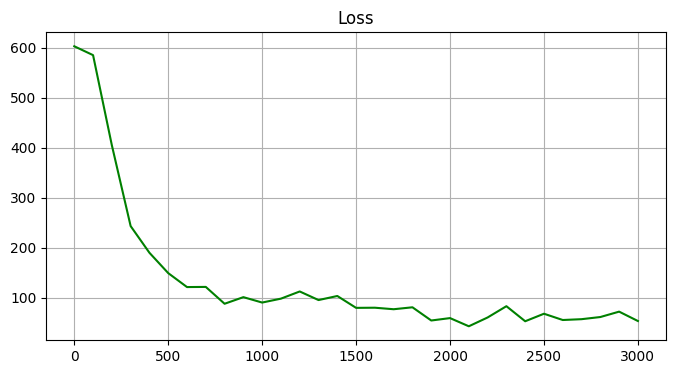

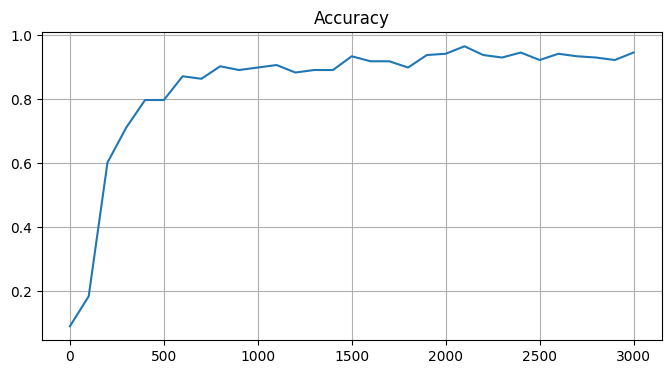

In [ ]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться
plt.figure(figsize=(8, 4))
plt.plot(np.linspace(0, 3000, 31), loss_history, c="green")
plt.title("Loss")
plt.grid()
plt.show()
plt.figure(figsize=(8, 4))
plt.plot(np.linspace(0, 3000, 31), accuracy_history)
plt.title("Accuracy")
plt.grid()
plt.show()

In [ ]:
# Вычислите точность обученной нейросети
pred_test = neural_net(x_test).numpy()
test_acc = accuracy(pred_test, y_test)
print(f"Accuracy of model with test data: Accuracy = {test_acc.numpy():.4f}")

Accuracy of model with test data: Accuracy = 0.9366


Accuracy = 1.00


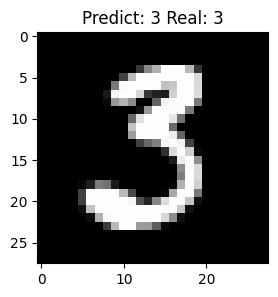

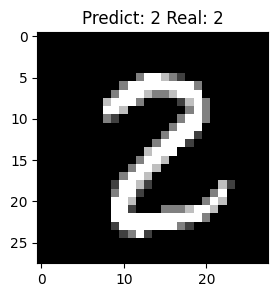

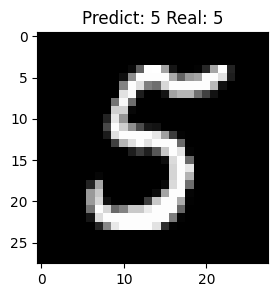

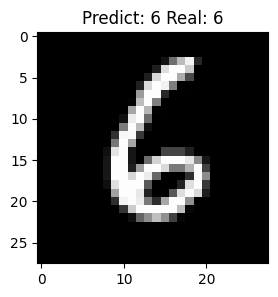

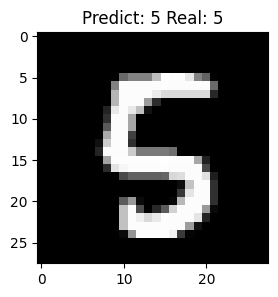

In [ ]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?
rand_idx = np.random.choice(len(x_test), 10, replace=False)
x_test_10 = x_test[rand_idx]
y_test_10 = y_test[rand_idx]
pred_10 = neural_net(x_test_10).numpy()
acc_10 = accuracy(pred_10, y_test_10)
pred_10 = pred_10.argmax(axis=1)

for i in range(5):
    plt.figure(figsize=(3, 3))
    plt.imshow(x_test_10[i].reshape(28, 28), cmap="gray")
    plt.title(f"Predict: {pred_10[i]} Real: {y_test_10[i]}")
    plt.show
print(f"Accuracy = {acc_10.numpy():.2f}")

#Висновок:
При данних параметрах нейронної мережі точність становить близько 0,94. Теоретично є можливість підвищити до 0,98